# Managing Big Data for Connected Devices

## 420-N63-NA

## Kawser Wazed Nafi
 ----------------------------------------------------------------------------------------------------------------------------------

# Linear Regression

In this we'll make use of the California Housing data set.

The data contains one row per census block group. A block group is the smallest geographical unit for which the U.S. Census Bureau publishes sample data (a block group typically has a population of 600 to 3,000 people). In this sample a block group on average includes 1425.5 individuals living in a geographically compact area.

These spatial data contain 20,640 observations on housing prices with 9 economic variables:

#### Longitude
refers to the angular distance of a geographic place north or south of the earth’s equator for each block group

#### Latitude 
refers to the angular distance of a geographic place east or west of the earth’s equator for each block group

#### Housing Median Age
is the median age of the people that belong to a block group. Note that the median is the value that lies at the midpoint of a frequency distribution of observed values
#### Total Rooms
is the total number of rooms in the houses per block group

#### Total Bedrooms
is the total number of bedrooms in the houses per block group

#### Population
is the number of inhabitants of a block group

#### Households
refers to units of houses and their occupants per block group

#### Median Income
is used to register the median income of people that belong to a block group

#### Median House Value
is the dependent variable and refers to the median house value per block group

In [1]:
# Install dependent libraries
!pip install mllib
!pip install pandas
!pip install numpy

  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Using cached setuptools-75.8.0-py3-none-any.whl.metadata (6.7 kB)
Using cached setuptools-75.8.0-py3-none-any.whl (1.2 MB)
  Created wheel for mllib: filename=mllib-1.0.0a2-py3-none-any.whl size=12008 sha256=42c56f17d715687df06a1512eb78c92e91a7d447da1d2f3c4b84d737ed5e6333
  Stored in directory: c:\users\hiche\appdata\local\pip\cache\wheels\87\60\14\3185b3416fe9f1c536d9f9cfbe5cc081897aa4588a06104a33
Successfully built mllib
   ---------------------------------------- 0.0/11.5 MB ? eta -:--:--
   ---- ----------------------------------- 1.3/11.5 MB 8.4 MB/s eta 0:00:02
   --------- ------------------------------ 2.6/11.5 MB 7.2 MB/s eta 0:00:02
   ----------- --

### Library Import

In [4]:
import os
import pandas as pd
import numpy as np

from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession, SQLContext

from pyspark.sql.types import *
import pyspark.sql.functions as F
from pyspark.sql.functions import udf, col

from pyspark.ml.regression import LinearRegression
from pyspark.mllib.evaluation import RegressionMetrics

from pyspark.ml.tuning import ParamGridBuilder, CrossValidator, CrossValidatorModel
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.evaluation import RegressionEvaluator

import seaborn as sns
import matplotlib.pyplot as plt

# Visualization
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

pd.set_option('display.max_columns', 200)
pd.set_option('display.max_colwidth', 400)

from matplotlib import rcParams
sns.set(context='notebook', style='whitegrid', rc={'figure.figsize': (18,4)})
rcParams['figure.figsize'] = 18,4

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# setting random seed for notebook reproducability
rnd_seed=23
np.random.seed=rnd_seed
np.random.set_state=rnd_seed

In [3]:
!pip install seaborn



   ---------------------------------------- 0.0/8.0 MB ? eta -:--:--
   ------ --------------------------------- 1.3/8.0 MB 6.7 MB/s eta 0:00:02
   ------ --------------------------------- 1.3/8.0 MB 6.7 MB/s eta 0:00:02
   ------- -------------------------------- 1.6/8.0 MB 2.3 MB/s eta 0:00:03
   ------- -------------------------------- 1.6/8.0 MB 2.3 MB/s eta 0:00:03
   --------- ------------------------------ 1.8/8.0 MB 1.6 MB/s eta 0:00:04
   --------- ------------------------------ 1.8/8.0 MB 1.6 MB/s eta 0:00:04
   ---------- ----------------------------- 2.1/8.0 MB 1.4 MB/s eta 0:00:05
   ----------- ---------------------------- 2.4/8.0 MB 1.3 MB/s eta 0:00:05
   ------------- -------------------------- 2.6/8.0 MB 1.4 MB/s eta 0:00:04
   ------------- -------------------------- 2.6/8.0 MB 1.4 MB/s eta 0:00:04
   ------------- -------------------------- 2.6/8.0 MB 1.4 MB/s eta 0:00:04
   --------------- ------------------------ 3.1/8.0 MB 1.2 MB/s eta 0:00:05
   --------------- 

In [11]:
!pip uninstall pyspark -y




Found existing installation: pyspark 3.5.4
Uninstalling pyspark-3.5.4:
  Successfully uninstalled pyspark-3.5.4


In [12]:
!pip install --upgrade pyspark


  Using cached pyspark-3.5.4-py2.py3-none-any.whl


In [1]:
import pyspark
print(pyspark.__version__)


3.5.4


### Spark Session Creation with SparkSQL

In [5]:
# Spark Session Creation

ss = SparkSession.builder.master("local[4]").appName("Linear-Regression").getOrCreate()
sc = ss.sparkContext
sqlContext = SQLContext(sc)

# Load data from file into dataframe
HOUSING_DATA = 'input/cal_housing.data'
# define the schema, corresponding to a line in the csv data file.
schema = StructType([
    StructField("long", FloatType(), nullable=True),
    StructField("lat", FloatType(), nullable=True),
    StructField("medage", FloatType(), nullable=True),
    StructField("totrooms", FloatType(), nullable=True),
    StructField("totbdrms", FloatType(), nullable=True),
    StructField("pop", FloatType(), nullable=True),
    StructField("houshlds", FloatType(), nullable=True),
    StructField("medinc", FloatType(), nullable=True),
    StructField("medhv", FloatType(), nullable=True)]
)
# Load housing data
housing_df = ss.read.csv(path=HOUSING_DATA, schema=schema).cache()

# Inspect first five rows
housing_df.take(5)

c:\Users\hiche\Desktop\Spark\venv\Lib\site-packages\pyspark\sql\context.py:113: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


[Row(long=-122.2300033569336, lat=37.880001068115234, medage=41.0, totrooms=880.0, totbdrms=129.0, pop=322.0, houshlds=126.0, medinc=8.325200080871582, medhv=452600.0),
 Row(long=-122.22000122070312, lat=37.86000061035156, medage=21.0, totrooms=7099.0, totbdrms=1106.0, pop=2401.0, houshlds=1138.0, medinc=8.301400184631348, medhv=358500.0),
 Row(long=-122.23999786376953, lat=37.849998474121094, medage=52.0, totrooms=1467.0, totbdrms=190.0, pop=496.0, houshlds=177.0, medinc=7.257400035858154, medhv=352100.0),
 Row(long=-122.25, lat=37.849998474121094, medage=52.0, totrooms=1274.0, totbdrms=235.0, pop=558.0, houshlds=219.0, medinc=5.643099784851074, medhv=341300.0),
 Row(long=-122.25, lat=37.849998474121094, medage=52.0, totrooms=1627.0, totbdrms=280.0, pop=565.0, houshlds=259.0, medinc=3.8461999893188477, medhv=342200.0)]

In [4]:
### Loaded Data View

In [6]:
# show the dataframe columns
housing_df.columns

# show the schema of the dataframe
housing_df.printSchema()

# run a sample selection
housing_df.select('pop','totbdrms').show(10)

# group by housingmedianage and see the distribution
result_df = housing_df.groupBy("medage").count().sort("medage", ascending=False)

result_df.show(10)

['long',
 'lat',
 'medage',
 'totrooms',
 'totbdrms',
 'pop',
 'houshlds',
 'medinc',
 'medhv']

root
 |-- long: float (nullable = true)
 |-- lat: float (nullable = true)
 |-- medage: float (nullable = true)
 |-- totrooms: float (nullable = true)
 |-- totbdrms: float (nullable = true)
 |-- pop: float (nullable = true)
 |-- houshlds: float (nullable = true)
 |-- medinc: float (nullable = true)
 |-- medhv: float (nullable = true)

+------+--------+
|   pop|totbdrms|
+------+--------+
| 322.0|   129.0|
|2401.0|  1106.0|
| 496.0|   190.0|
| 558.0|   235.0|
| 565.0|   280.0|
| 413.0|   213.0|
|1094.0|   489.0|
|1157.0|   687.0|
|1206.0|   665.0|
|1551.0|   707.0|
+------+--------+
only showing top 10 rows

+------+-----+
|medage|count|
+------+-----+
|  52.0| 1273|
|  51.0|   48|
|  50.0|  136|
|  49.0|  134|
|  48.0|  177|
|  47.0|  198|
|  46.0|  245|
|  45.0|  294|
|  44.0|  356|
|  43.0|  353|
+------+-----+
only showing top 10 rows



### Summary Statistics

Spark DataFrames include some built-in functions for statistical processing. The describe() function performs summary statistics calculations on all numeric columns and returns them as a DataFrame.

In [ ]:
# describe() function to generate summary statistics for all numeric columns in the DataFrame housing_df
(housing_df.describe().select(
                    "summary",
                    F.round("medage", 4).alias("medage"), # rounds numbers to 4 decimal places.
                    F.round("totrooms", 4).alias("totrooms"),
                    F.round("totbdrms", 4).alias("totbdrms"),
                    F.round("pop", 4).alias("pop"),
                    F.round("houshlds", 4).alias("houshlds"),
                    F.round("medinc", 4).alias("medinc"),
                    F.round("medhv", 4).alias("medhv"))
                    .show()) # The show() function prints the summary statistics as a table.

+-------+-------+---------+--------+---------+--------+-------+-----------+
|summary| medage| totrooms|totbdrms|      pop|houshlds| medinc|      medhv|
+-------+-------+---------+--------+---------+--------+-------+-----------+
|  count|20640.0|  20640.0| 20640.0|  20640.0| 20640.0|20640.0|    20640.0|
|   mean|28.6395|2635.7631| 537.898|1425.4767|499.5397| 3.8707|206855.8169|
| stddev|12.5856|2181.6153|421.2479|1132.4621|382.3298| 1.8998|115395.6159|
|    min|    1.0|      2.0|     1.0|      3.0|     1.0| 0.4999|    14999.0|
|    max|   52.0|  39320.0|  6445.0|  35682.0|  6082.0|15.0001|   500001.0|
+-------+-------+---------+--------+---------+--------+-------+-----------+



Look at the minimum and maximum values of all the (numerical) attributes. We see that multiple attributes have a wide range of values: we will need to normalize your dataset.

### EXPLANATION
Wide ranges can negatively impact machine learning models, so normalization (scaling values to a smaller range) is necessary.

### Data Preprocessing

With all this information that we gathered from our small exploratory data analysis, we know enough to preprocess our data to feed it to the model.

1. we shouldn't care about missing values; all zero values have been excluded from the data set.
2. We should probably standardize our data, as we have seen that the range of minimum and maximum values is quite big.
3. There are possibly some additional attributes that we could add, such as a feature that registers the number of bedrooms per room or the rooms per household.
4. Our dependent variable is also quite big; To make our life easier, we'll have to adjust the values slightly.

### EXPLANATION
Standardization of Data

Because different attributes have widely varying scales, standardization (transforming values to have a mean of 0 and a standard deviation of 1) will help improve model performance.

### Preprocessing The Target Values
First, let's start with the medianHouseValue, our dependent variable. To facilitate our working with the target values, we will express the house values in units of 100,000. That means that a target such as 452600.000000 should become 4.526:

### EXPLANATION:
Explanation of Preprocessing the Target Values
This section describes how to adjust the target variable (medianHouseValue) in the dataset to make it easier to work with.

Why Modify the Target Variable?
The median house value (medhv) has large values (e.g., 452600).
To make computations simpler and more interpretable, the values are scaled down by dividing by 100,000.
Example transformation:
452600 → 4.526
358500 → 3.585

### KEY TAKEAWAYS
Scaling the target variable helps models perform better by keeping values within a smaller range.
It doesn’t change the relationships between values, just makes them easier to handle.
This preprocessing step is common in machine learning to improve numerical stability.

In [7]:
# Adjust the values of `medianHouseValue`
housing_df = housing_df.withColumn("medhv", col("medhv")/100000)
housing_df.show(2)

+-------+-----+------+--------+--------+------+--------+------+-----+
|   long|  lat|medage|totrooms|totbdrms|   pop|houshlds|medinc|medhv|
+-------+-----+------+--------+--------+------+--------+------+-----+
|-122.23|37.88|  41.0|   880.0|   129.0| 322.0|   126.0|8.3252|4.526|
|-122.22|37.86|  21.0|  7099.0|  1106.0|2401.0|  1138.0|8.3014|3.585|
+-------+-----+------+--------+--------+------+--------+------+-----+
only showing top 2 rows



### Feature Engineering / Selection from Sample

Now that we have adjusted the values in medianHouseValue, we will now add the following columns to the data set:

1. Rooms per household which refers to the number of rooms in households per block group;
2. Population per household, which basically gives us an indication of how many people live in households per block group; And
3. Bedrooms per room which will give us an idea about how many rooms are bedrooms per block group;

As we're working with DataFrames, we can best use the select() method to select the columns that we're going to be working with, namely totalRooms, households, and population. Additionally, we have to indicate that we're working with columns by adding the col() function to our code. Otherwise, we won't be able to do element-wise operations like the division that we have in mind for these three variables:

### Key Takeaways:
Feature engineering helps extract meaningful insights from raw data.
These new features can improve machine learning model performance.

### Explanation:
Feature Engineering / Selection from Sample
This section explains how to create new features from existing columns to make the data more informative for modeling.

In [ ]:
housing_df.columns

# Add the new columns to `df`
# Computes Total number of rooms per household and rounds to 2 decimal places.
housing_df = (housing_df.withColumn("rmsperhh", F.round(col("totrooms")/col("houshlds"), 2))
                       .withColumn("popperhh", F.round(col("pop")/col("houshlds"), 2))#Computes Total number of population per household.
                       .withColumn("bdrmsperrm", F.round(col("totbdrms")/col("totrooms"), 2)))#Computes how many bedrooms exist per total number of room.

# Inspect the result
housing_df.show(5)

['long',
 'lat',
 'medage',
 'totrooms',
 'totbdrms',
 'pop',
 'houshlds',
 'medinc',
 'medhv']

+-------+-----+------+--------+--------+------+--------+------+-----+--------+--------+----------+
|   long|  lat|medage|totrooms|totbdrms|   pop|houshlds|medinc|medhv|rmsperhh|popperhh|bdrmsperrm|
+-------+-----+------+--------+--------+------+--------+------+-----+--------+--------+----------+
|-122.23|37.88|  41.0|   880.0|   129.0| 322.0|   126.0|8.3252|4.526|    6.98|    2.56|      0.15|
|-122.22|37.86|  21.0|  7099.0|  1106.0|2401.0|  1138.0|8.3014|3.585|    6.24|    2.11|      0.16|
|-122.24|37.85|  52.0|  1467.0|   190.0| 496.0|   177.0|7.2574|3.521|    8.29|     2.8|      0.13|
|-122.25|37.85|  52.0|  1274.0|   235.0| 558.0|   219.0|5.6431|3.413|    5.82|    2.55|      0.18|
|-122.25|37.85|  52.0|  1627.0|   280.0| 565.0|   259.0|3.8462|3.422|    6.28|    2.18|      0.17|
+-------+-----+------+--------+--------+------+--------+------+-----+--------+--------+----------+
only showing top 5 rows



We can see that, for the first row, there are about 6.98 rooms per household, the households in the block group consist of about 2.5 people and the amount of bedrooms is quite low with 0.14:

Since we don't want to necessarily standardize our target values, we'll want to make sure to isolate those in our data set. Note also that this is the time to leave out variables that we might not want to consider in our analysis. In this case, let's leave out variables such as longitude, latitude, housingMedianAge and totalRooms.

In this case, we will use the select() method and passing the column names in the order that is more appropriate. In this case, the target variable medianHouseValue is put first, so that it won't be affected by the standardization.

### Explanation of the following code:
Final Column Selection and Feature Extraction
This step reorders the dataset and selects the most relevant features for training a machine learning model.

In [7]:
# Re-order and select columns
housing_df = housing_df.select("medhv", 
                               "medage",
                              "totbdrms", 
                              "pop", 
                              "houshlds", 
                              "medinc", 
                              "rmsperhh", 
                              "popperhh", 
                              "bdrmsperrm")

#### Feature Extraction

featureCols = ["totbdrms", "pop", "houshlds", "medinc", "rmsperhh", "popperhh", "bdrmsperrm", "medage"]


AnalysisException: [UNRESOLVED_COLUMN.WITH_SUGGESTION] A column or function parameter with name `rmsperhh` cannot be resolved. Did you mean one of the following? [`medhv`, `medage`, `medinc`, `pop`, `lat`].;
'Project [medhv#8, medage#2, totbdrms#4, pop#5, houshlds#6, medinc#7, 'rmsperhh, 'popperhh, 'bdrmsperrm]
+- Relation [long#0,lat#1,medage#2,totrooms#3,totbdrms#4,pop#5,houshlds#6,medinc#7,medhv#8] csv


### Key Takeaways:
Key Takeaways
✅ Feature selection is complete—only the most important variables remain.
✅ Feature extraction is ready—these features will be used for model training.
✅ Next step: Data Scaling & Model Training. 🚀

### Class label formulation

Classification is supervised learning. To predict the proper class label for any data, we need to provide label information for each class and the class range to properly separate the classes from one class to another.

For our example, we are going to use four classes based on the medhv values we configured in previous steps. The class distribution is given over here.

| Medhv Range  | Class Label        |
|--------------|--------------------|
| < 1.0        | 0 / 'first class'  |
| < 2.0 >= 1.0 | 1 / 'second class' |
| < 3.0 >= 2.0 | 2 / 'third class'  |
| >= 3.0       | 3 / 'fourth class' |

Our target is to learn the class labels based on the feature columns in such a way that if new data comes from each of the feature columns, the model can predict the class label properly.s'  |

### Explanation:
Class Label Formulation (Classification Problem)
This section prepares the data for classification modeling by assigning class labels based on the medhv (median house value) variable.

In [ ]:
# Each row in the dataset is assigned a class label based on these ranges.
# Creates a new column "label", assigning class labels based on the value of "medhv".
# F.when(condition, value) checks conditions and assigns values accordingly:
classification_df = housing_df.withColumn(
    "label",
    # If medhv < 1.0, assign 0.
    F.when(col("medhv") < 1.0, 0) # First class
     .when((col("medhv") >= 1.0) & (col("medhv") < 2.0), 1) # Second class
     .when((col("medhv") >= 2.0) & (col("medhv") < 3.0), 2) # Third class
      # Otherwise (medhv >= 3.0), assign 3.
     .otherwise(3) # Fourth class
)
# Selects only the label and feature columns, removing unnecessary columns.
classification_df = classification_df.select("label", *featureCols)
classification_df.take(5)

[Row(label=3, totbdrms=129.0, pop=322.0, houshlds=126.0, medinc=8.325200080871582, rmsperhh=6.98, popperhh=2.56, bdrmsperrm=0.15, medage=41.0),
 Row(label=3, totbdrms=1106.0, pop=2401.0, houshlds=1138.0, medinc=8.301400184631348, rmsperhh=6.24, popperhh=2.11, bdrmsperrm=0.16, medage=21.0),
 Row(label=3, totbdrms=190.0, pop=496.0, houshlds=177.0, medinc=7.257400035858154, rmsperhh=8.29, popperhh=2.8, bdrmsperrm=0.13, medage=52.0),
 Row(label=3, totbdrms=235.0, pop=558.0, houshlds=219.0, medinc=5.643099784851074, rmsperhh=5.82, popperhh=2.55, bdrmsperrm=0.18, medage=52.0),
 Row(label=3, totbdrms=280.0, pop=565.0, houshlds=259.0, medinc=3.8461999893188477, rmsperhh=6.28, popperhh=2.18, bdrmsperrm=0.17, medage=52.0)]

### Explanation:
Key Takeaways
✅ We transformed a regression problem into a classification problem.
✅ Each house is now labeled into one of four categories based on its price.
✅ This dataset is now ready for training a classification model.

#### Use a VectorAssembler 

##### put features into a feature vector column

### Explanation:
Using VectorAssembler to Prepare Features for Machine Learning
In this step, we use VectorAssembler to combine multiple feature columns into a single feature vector column. This is necessary because Apache Spark ML expects features to be in a single vector format.
### Why is this important?
✅ Prepares data for machine learning
✅ Combines all numerical features into one vector column
✅ Enables Spark ML algorithms to process the data efficiently

In [ ]:
# Assemble features
# Create a VectorAssembler

# inputCols=featureCols: Specifies the columns we want to combine into a feature vector.
# outputCol="features": Defines the new column name that will store the assembled feature vectors.
assembler = VectorAssembler(inputCols=featureCols, outputCol="features")
# Applies the transformation to create a new "features" column.
assembled_class_df = assembler.transform(classification_df)
assembled_class_df.take(5)




[Row(label=3, totbdrms=129.0, pop=322.0, houshlds=126.0, medinc=8.325200080871582, rmsperhh=6.98, popperhh=2.56, bdrmsperrm=0.15, medage=41.0, features=DenseVector([129.0, 322.0, 126.0, 8.3252, 6.98, 2.56, 0.15, 41.0])),
 Row(label=3, totbdrms=1106.0, pop=2401.0, houshlds=1138.0, medinc=8.301400184631348, rmsperhh=6.24, popperhh=2.11, bdrmsperrm=0.16, medage=21.0, features=DenseVector([1106.0, 2401.0, 1138.0, 8.3014, 6.24, 2.11, 0.16, 21.0])),
 Row(label=3, totbdrms=190.0, pop=496.0, houshlds=177.0, medinc=7.257400035858154, rmsperhh=8.29, popperhh=2.8, bdrmsperrm=0.13, medage=52.0, features=DenseVector([190.0, 496.0, 177.0, 7.2574, 8.29, 2.8, 0.13, 52.0])),
 Row(label=3, totbdrms=235.0, pop=558.0, houshlds=219.0, medinc=5.643099784851074, rmsperhh=5.82, popperhh=2.55, bdrmsperrm=0.18, medage=52.0, features=DenseVector([235.0, 558.0, 219.0, 5.6431, 5.82, 2.55, 0.18, 52.0])),
 Row(label=3, totbdrms=280.0, pop=565.0, houshlds=259.0, medinc=3.8461999893188477, rmsperhh=6.28, popperhh=2.18

[Row(label=3, totbdrms=129.0, pop=322.0, houshlds=126.0, medinc=8.325200080871582, rmsperhh=6.98, popperhh=2.56, bdrmsperrm=0.15, medage=41.0, features=DenseVector([129.0, 322.0, 126.0, 8.3252, 6.98, 2.56, 0.15, 41.0]), features_scaled=DenseVector([0.3062, 0.2843, 0.3296, 4.3821, 2.8211, 0.2465, 2.5829, 3.2577])),
 Row(label=3, totbdrms=1106.0, pop=2401.0, houshlds=1138.0, medinc=8.301400184631348, rmsperhh=6.24, popperhh=2.11, bdrmsperrm=0.16, medage=21.0, features=DenseVector([1106.0, 2401.0, 1138.0, 8.3014, 6.24, 2.11, 0.16, 21.0]), features_scaled=DenseVector([2.6255, 2.1202, 2.9765, 4.3696, 2.522, 0.2032, 2.7551, 1.6686])),
 Row(label=3, totbdrms=190.0, pop=496.0, houshlds=177.0, medinc=7.257400035858154, rmsperhh=8.29, popperhh=2.8, bdrmsperrm=0.13, medage=52.0, features=DenseVector([190.0, 496.0, 177.0, 7.2574, 8.29, 2.8, 0.13, 52.0]), features_scaled=DenseVector([0.451, 0.438, 0.463, 3.82, 3.3506, 0.2696, 2.2385, 4.1317])),
 Row(label=3, totbdrms=235.0, pop=558.0, houshlds=219.

### Standarization

Next, we can finally scale the data using StandardScaler. The input columns are the features, and the output column with the rescaled that will be included in the scaled_df will be named "features_scaled":

### Explanation:
Why Standardization?
Features have different units and magnitudes (e.g., population counts in thousands, income in decimal values).
StandardScaler transforms features to zero mean and unit variance:
𝑋
scaled
=
𝑋
−
𝜇
𝜎
X 
scaled
​
 = 
σ
X−μ
​
 
where 
𝜇
μ is the mean and 
𝜎
σ is the standard deviation.

In [ ]:
# Scale the features
standardScaler = StandardScaler(inputCol="features", outputCol="features_scaled")
scaled_class_df = standardScaler.fit(assembled_class_df).transform(assembled_class_df)
scaled_class_df.take(5)
# How This Works:
# Create StandardScaler

# inputCol="features": Uses the previously assembled feature vector.
# outputCol="features_scaled": Stores the rescaled values.
# Fit and Transform the Data

# .fit(assembled_class_df): Learns the scaling factors from the dataset.
# .transform(assembled_class_df): Applies scaling to each feature.

[Row(label=3, totbdrms=129.0, pop=322.0, houshlds=126.0, medinc=8.325200080871582, rmsperhh=6.98, popperhh=2.56, bdrmsperrm=0.15, medage=41.0, features=DenseVector([129.0, 322.0, 126.0, 8.3252, 6.98, 2.56, 0.15, 41.0]), features_scaled=DenseVector([0.3062, 0.2843, 0.3296, 4.3821, 2.8211, 0.2465, 2.5829, 3.2577])),
 Row(label=3, totbdrms=1106.0, pop=2401.0, houshlds=1138.0, medinc=8.301400184631348, rmsperhh=6.24, popperhh=2.11, bdrmsperrm=0.16, medage=21.0, features=DenseVector([1106.0, 2401.0, 1138.0, 8.3014, 6.24, 2.11, 0.16, 21.0]), features_scaled=DenseVector([2.6255, 2.1202, 2.9765, 4.3696, 2.522, 0.2032, 2.7551, 1.6686])),
 Row(label=3, totbdrms=190.0, pop=496.0, houshlds=177.0, medinc=7.257400035858154, rmsperhh=8.29, popperhh=2.8, bdrmsperrm=0.13, medage=52.0, features=DenseVector([190.0, 496.0, 177.0, 7.2574, 8.29, 2.8, 0.13, 52.0]), features_scaled=DenseVector([0.451, 0.438, 0.463, 3.82, 3.3506, 0.2696, 2.2385, 4.1317])),
 Row(label=3, totbdrms=235.0, pop=558.0, houshlds=219.

### Explanation:
Key Takeaways
✅ Prepares data for machine learning models by standardizing different feature magnitudes.
✅ Improves numerical stability and model performance.
✅ Necessary for distance-based models like Logistic Regression, KNN, SVM.

### Building The ML Model
#### Creating and ElasticNet 

ElasticNet is a linear regression model trained with L1 and L2 prior as regularizer. This combination allows for learning a sparse model where few of the weights are non-zero like Lasso, while still maintaining the regularization properties of Ridge. We control the convex combination of L1 and L2 using the l1_ratio parameterElastic-Net can be used for classification as well. Here, regressed lines going to be generated from different features are going to put the data to different class labels, based on learned values.tation.

### Explanation: 
This section shows how to train an ElasticNet model using PySpark's MLlib.

### DEFINITIONS:
### VectorAssembler
What is it?
VectorAssembler combines multiple feature columns into a single vector column.
Many ML models in PySpark require all features to be in a single vector.
### how it works:
How it Works
inputCols=featureCols → Specifies the original feature columns.
outputCol="features" → Creates a new column (features) containing a vector of all selected features.
.transform(df) → Applies the transformation to convert feature columns into a vector column.

### .transform()
.transform()
What is it?
.transform() applies a transformation to a DataFrame.
Used with feature engineering, data scaling, and predictions.

### .fit()
What is it?
.fit() trains a machine learning model using training data.
It learns from the data and returns a trained model.

In [ ]:
# Split the data into training and test sets
# Splitting the Data

# randomSplit([.8, .2], seed=rnd_seed):
# 80% for training, 20% for testing.
# seed=rnd_seed: Ensures reproducibility.
# train_data, test_data = scaled_class_df.randomSplit([.8, .2], seed=rnd_seed)
# Use Elastic Net Linear Regression
from pyspark.ml.regression import LinearRegression

lr = LinearRegression(
    featuresCol="features_scaled",  # Input features column
    labelCol="label",               # Target column
    predictionCol="prediction",      # Output prediction column
    maxIter=10,                      # Max iterations for optimization
    regParam=0.3,                     # Regularization strength
    elasticNetParam=0.8               # ElasticNet mixing (0=L2, 1=L1)
)

elasticNetModel = lr.fit(train_data)  # Train the model

In [ ]:
## Evaluating the model
# Coefficients for the model
elasticNetModel.coefficients
# What This Means:
# The coefficients determine how much each feature contributes to the prediction.
# Many coefficients are 0, meaning ElasticNet has selected only some features while ignoring others.
# The only non-zero coefficient is for "medinc" (median income), 
# meaning it's the most important predictor of house price categories.

DenseVector([0.0, 0.0, 0.0, 0.3539, 0.0, 0.0, 0.0, 0.0])

In [ ]:
# Intercept for the model
elasticNetModel.intercept
# What This Means:
# The intercept represents the baseline value when all feature values are 0.

0.7178530381089424

In [ ]:
coeff_df = pd.DataFrame({"Feature": ["Intercept"] + featureCols, "Co-efficients": np.insert(elasticNetModel.coefficients.toArray(), 0, elasticNetModel.intercept)})
coeff_df = coeff_df[["Feature", "Co-efficients"]]
# coeff_dfKey Takeaways
# ✅ ElasticNet performed feature selection—only "medinc" (median income) is important.
# ✅ Other features have zero coefficients, meaning they have little or no effect on the predictions.
# ✅ The intercept is 0.717, setting a baseline prediction.

,Feature,Co-efficients
0,Intercept,0.717853
1,totbdrms,0.000000
2,pop,0.000000
3,houshlds,0.000000
4,medinc,0.353867
5,rmsperhh,0.000000
6,popperhh,0.000000
7,bdrmsperrm,0.000000
8,medage,0.000000


### Generating Predictions Using ElasticNet
This section explains how to use the trained ElasticNet model to make predictions and convert the regression outputs into class labels.

In [ ]:
# Generate predictions
predictions = elasticNetModel.transform(test_data)
predictions.take(5)
# How It Works:
# .transform(test_data) → Uses the trained model to predict labels for the test dataset.
# The output includes:
# label → The actual class from the dataset.
# prediction → The regression output from the model.

# Convert regression outputs to class predictions using rounding
predictions = predictions.withColumn("class_prediction", F.round(col("prediction")).cast("double"))
predictions.take(5)
# How It Works:
# F.round(col("prediction")) → Rounds the regression output to the nearest whole number.
# .cast("double") → Ensures the column data type is numeric.
# Creates a new column "class_prediction" containing the final class labels.

[Row(label=0, totbdrms=2.0, pop=8.0, houshlds=2.0, medinc=1.625, rmsperhh=3.0, popperhh=4.0, bdrmsperrm=0.33, medage=1.0, features=DenseVector([2.0, 8.0, 2.0, 1.625, 3.0, 4.0, 0.33, 1.0]), features_scaled=DenseVector([0.0047, 0.0071, 0.0052, 0.8553, 1.2125, 0.3851, 5.6823, 0.0795]), prediction=1.0205310529552487),
 Row(label=0, totbdrms=7.0, pop=55.0, houshlds=7.0, medinc=7.575200080871582, rmsperhh=3.14, popperhh=7.86, bdrmsperrm=0.32, medage=52.0, features=DenseVector([7.0, 55.0, 7.0, 7.5752, 3.14, 7.86, 0.32, 52.0]), features_scaled=DenseVector([0.0166, 0.0486, 0.0183, 3.9873, 1.2691, 0.7568, 5.5101, 4.1317]), prediction=2.1288355135192742),
 Row(label=0, totbdrms=8.0, pop=13.0, houshlds=8.0, medinc=2.375, rmsperhh=6.0, popperhh=1.63, bdrmsperrm=0.17, medage=26.0, features=DenseVector([8.0, 13.0, 8.0, 2.375, 6.0, 1.63, 0.17, 26.0]), features_scaled=DenseVector([0.019, 0.0115, 0.0209, 1.2501, 2.425, 0.1569, 2.9273, 2.0659]), prediction=1.1602285982689284),
 Row(label=0, totbdrms=10.0

[Row(label=0, totbdrms=2.0, pop=8.0, houshlds=2.0, medinc=1.625, rmsperhh=3.0, popperhh=4.0, bdrmsperrm=0.33, medage=1.0, features=DenseVector([2.0, 8.0, 2.0, 1.625, 3.0, 4.0, 0.33, 1.0]), features_scaled=DenseVector([0.0047, 0.0071, 0.0052, 0.8553, 1.2125, 0.3851, 5.6823, 0.0795]), prediction=1.0205310529552487, class_prediction=1.0),
 Row(label=0, totbdrms=7.0, pop=55.0, houshlds=7.0, medinc=7.575200080871582, rmsperhh=3.14, popperhh=7.86, bdrmsperrm=0.32, medage=52.0, features=DenseVector([7.0, 55.0, 7.0, 7.5752, 3.14, 7.86, 0.32, 52.0]), features_scaled=DenseVector([0.0166, 0.0486, 0.0183, 3.9873, 1.2691, 0.7568, 5.5101, 4.1317]), prediction=2.1288355135192742, class_prediction=2.0),
 Row(label=0, totbdrms=8.0, pop=13.0, houshlds=8.0, medinc=2.375, rmsperhh=6.0, popperhh=1.63, bdrmsperrm=0.17, medage=26.0, features=DenseVector([8.0, 13.0, 8.0, 2.375, 6.0, 1.63, 0.17, 26.0]), features_scaled=DenseVector([0.019, 0.0115, 0.0209, 1.2501, 2.425, 0.1569, 2.9273, 2.0659]), prediction=1.16

### Key Takeaways
✅ Predictions are generated for test data.
✅ Regression outputs are rounded to create final class labels.
✅ The model is now ready for accuracy evaluation.

### Evaluation
### Evaluation Metrics
Why use Accuracy and F1-score?
Accuracy: Measures how many predictions were correct.
F1-score: Balances precision and recall, useful when classes are imbalanced.

In [ ]:
# Evaluate the model using MulticlassClassificationEvaluator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Accuracy Evaluator
evaluator_accuracy = MulticlassClassificationEvaluator(
    labelCol="label", 
    predictionCol="class_prediction", 
    metricName="accuracy"
)

# F1-score Evaluator
evaluator_f1 = MulticlassClassificationEvaluator(
    labelCol="label", 
    predictionCol="class_prediction", 
    metricName="f1"
)

# Compute Evaluation Scores
accuracy = evaluator_accuracy.evaluate(predictions)
f1_score = evaluator_f1.evaluate(predictions)

# Print Results
print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1_score}")

Accuracy: 0.45713595749818886
F1 Score: 0.3698116654880567


### Interpretation of Results
Accuracy = 45.7% → The model correctly predicts the house value class 45.7% of the time.<br>
F1-score = 36.9% → The model balances precision and recall at 36.9%.<br>
#### Why is F1-score lower than Accuracy?
The model may struggle with some classes more than others.<br>
There might be class imbalance where some categories have more samples than others.

### Extract predictions and true labels



In [ ]:
predandlabels = predictions.select("label", "class_prediction", "prediction")
predandlabels.show()
# How It Works:
# select("label", "class_prediction", "prediction")

# Extracts the actual label (label).
# Extracts the rounded classification prediction (class_prediction).
# Extracts the raw regression prediction (prediction).
# .show()

# Displays the first few rows of predictions.

+-----+----------------+------------------+
|label|class_prediction|        prediction|
+-----+----------------+------------------+
|    0|             1.0|1.0205310529552487|
|    0|             2.0|2.1288355135192742|
|    0|             1.0|1.1602285982689284|
|    0|             2.0|1.5280987831648238|
|    0|             1.0|0.8176902196466702|
|    0|             1.0|1.0942541253761675|
|    0|             1.0|0.9739652045173555|
|    0|             1.0|0.8176902196466702|
|    0|             1.0|1.0857232452091647|
|    0|             1.0|0.8774993947408157|
|    0|             1.0|1.3930578404583949|
|    0|             1.0| 1.097364685114311|
|    0|             1.0|1.1951529845973485|
|    0|             1.0|0.9914367012945107|
|    0|             1.0|0.8715575945939924|
|    0|             1.0|0.9488941436537821|
|    0|             1.0|0.9273993560794621|
|    0|             1.0|1.1555719956616777|
|    0|             1.0|1.3413138541844694|
|    0|             1.0| 1.13694

<Axes: xlabel='label', ylabel='count'>

Text(0.5, 1.0, 'True Labels vs Predicted Classes')

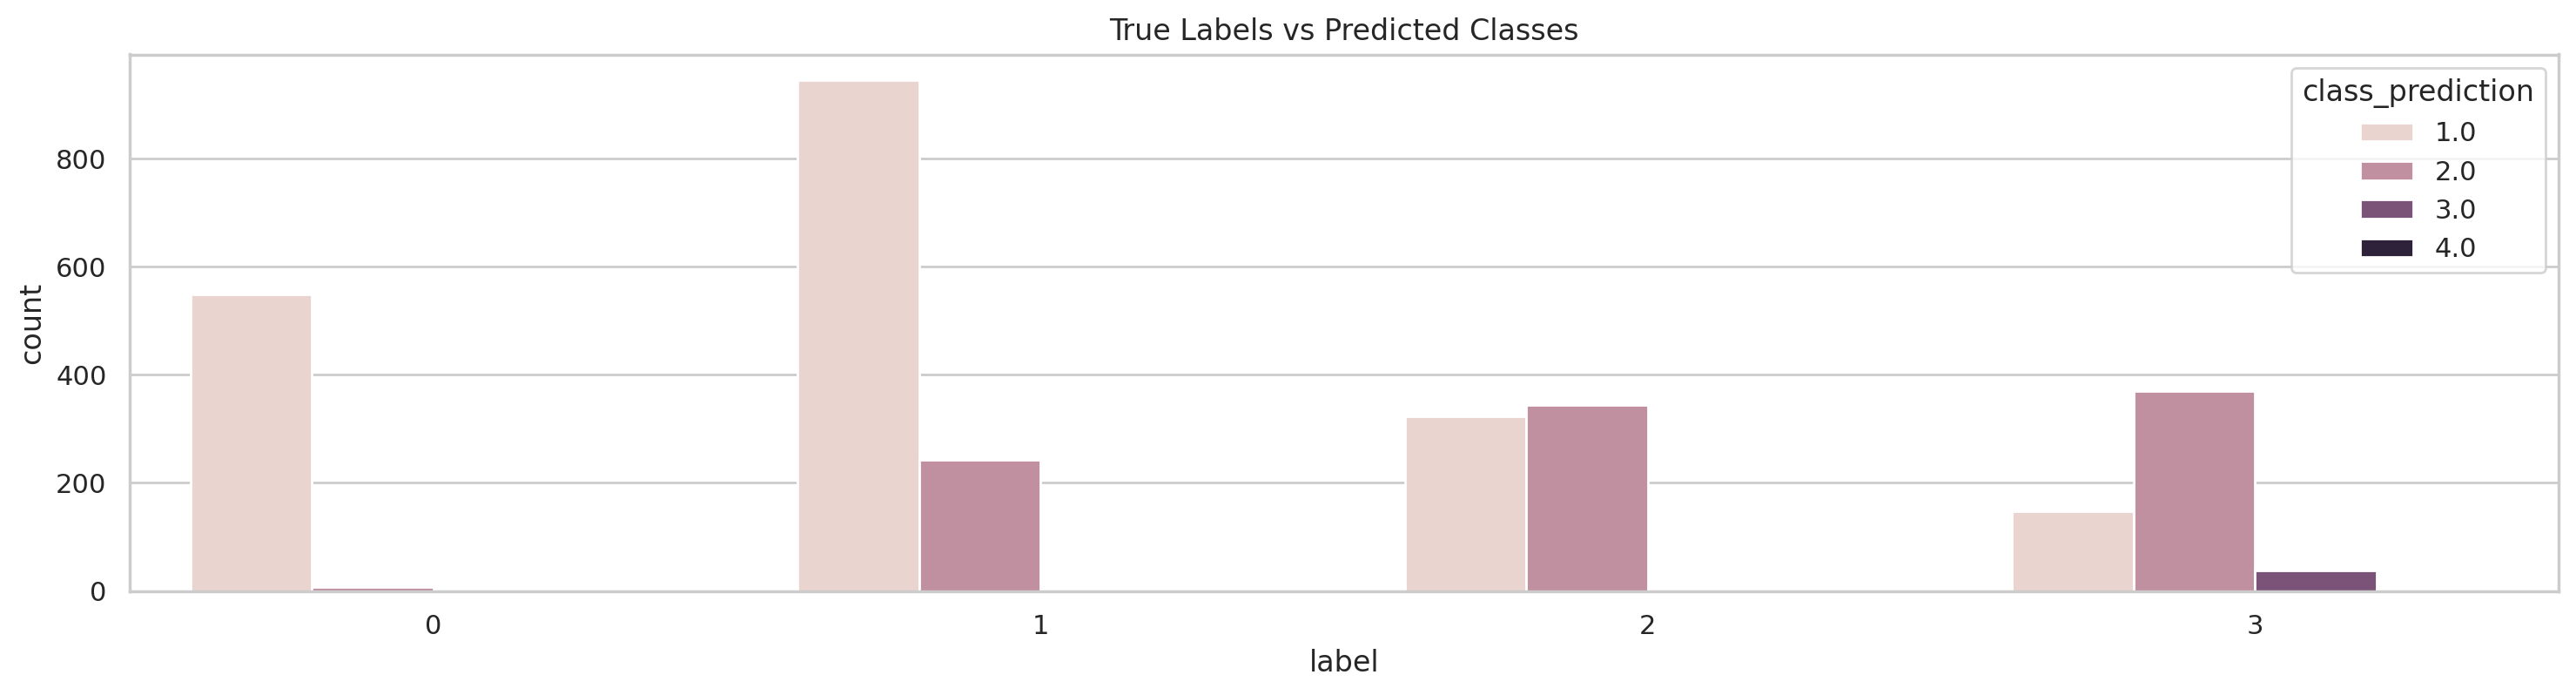

In [ ]:
# Visualization
classification_df_sample = predictions.select(['label', 'class_prediction']).sample(False, 0.7, 42)
classification_pandas_df = classification_df_sample.toPandas()

sns.countplot(data=classification_pandas_df, x='True Label', hue='class_prediction')
plt.title('True Labels vs Predicted Classes')
plt.show()
# How It Works:
# Extracts the necessary columns → label (true class) and class_prediction (predicted class).
# Samples 70% of the data to make the plot manageable.
# Converts the data to Pandas using .toPandas() (since Seaborn works with Pandas).
# Creates a countplot:
# x='label' → X-axis represents true labels.
# hue='class_prediction' → Different colors show predicted classes.
# Displays the plot.

### Interpreting the Visualization
The bars represent the count of true labels.<br>
The shaded sections within bars show predicted class distributions.<br>
If a single color dominates a true label, the model predicted correctly.<br>
If multiple colors appear for a true label, the model made misclassifications.
### Key Observations
✅ Class 1 is often misclassified as Class 2.<br>
✅ Class 3 predictions show some overlap with Class 2.<br>
✅ Few predictions for Class 4, suggesting an imbalance.

## Exercise 1

Please consider the attached insurance.csv file. In this file, you have 4 numerical columns, age, bmi, no of children and charges. And other 3 columns, sex, smoker and region are String data.

Our target is to get a classified insurance charges based on the given data in the insurance.csv file. Please use three numerical columns, age, bmi and no of children as features to generate the regression classification model. Perform the evaluation with different metrics to find out the accuracy of the model in generating regressed classification. And use the following table to generate the classification label:


| Charges Range | Class Label        |
|--------------|--------------------|
| < 5000        | 0 / 'Lowest Insurance'  |
| < 10000 >= 5000 | 1 / 'Mid-Lowest Insurance' |
| < 16000 >= 10000 | 2 / 'Mid Insurance'  |
| < 21000 >= 16000 | 3 / 'Higher-Mid Insurance'  |
| >= 21000       | 4 / 'Highest Insurance' |



In [10]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import when, col
from pyspark.ml.feature import VectorAssembler, StandardScaler, StringIndexer
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Initialize Spark
spark = SparkSession.builder.appName("Insurance_Classification").getOrCreate()

# Load Dataset
df = spark.read.csv("insurance.csv", header=True, inferSchema=True)

# Encode categorical columns
indexer_sex = StringIndexer(inputCol="sex", outputCol="sex_indexed").fit(df)
df = indexer_sex.transform(df)

indexer_smoker = StringIndexer(inputCol="smoker", outputCol="smoker_indexed").fit(df)
df = indexer_smoker.transform(df)

indexer_region = StringIndexer(inputCol="region", outputCol="region_indexed").fit(df)
df = indexer_region.transform(df)

# Select relevant features
features = ["age", "bmi", "children", "sex_indexed", "smoker_indexed", "region_indexed"]
target = "charges"

# Convert features into a single vector
assembler = VectorAssembler(inputCols=features, outputCol="features")
df = assembler.transform(df)

# Standardize features
scaler = StandardScaler(inputCol="features", outputCol="features_scaled")
df = scaler.fit(df).transform(df)

# Convert charges to categorical labels
df = df.withColumn(
    "class_label",
    when(col("charges") < 5000, 0)
    .when((col("charges") >= 5000) & (col("charges") < 10000), 1)
    .when((col("charges") >= 10000) & (col("charges") < 16000), 2)
    .when((col("charges") >= 16000) & (col("charges") < 21000), 3)
    .otherwise(4)
)

# Train Classification Model (Logistic Regression)
lr = LogisticRegression(featuresCol="features_scaled", labelCol="class_label", predictionCol="prediction")
model = lr.fit(df)

# Generate predictions
predictions = model.transform(df)

# Evaluate Model
evaluator_accuracy = MulticlassClassificationEvaluator(
    labelCol="class_label", predictionCol="prediction", metricName="accuracy"
)

accuracy = evaluator_accuracy.evaluate(predictions)
print(f"Accuracy: {accuracy}")

Accuracy: 0.8340807174887892


## Exercise 2

Please consider all the columns present in insurance.csv file to regress the charges values. Keep the numerical columns unchanged and encode the columns with String values with One-Hot encoding. Perform Linear Regression Classification on the dataset and check whether the accuracy of class prediction for charges has increased or not.

For accuracy comparison used the evaluation metrics provided in this tutorial.

In [12]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import when, col
from pyspark.ml.feature import VectorAssembler, StandardScaler, OneHotEncoder, StringIndexer
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql.types import DoubleType

# Initialize Spark
spark = SparkSession.builder.appName("Insurance_LinearRegression").getOrCreate()

# Load Dataset
df = spark.read.csv("insurance.csv", header=True, inferSchema=True)

# One-Hot Encoding for Categorical Features
indexer = StringIndexer(inputCols=["sex", "smoker", "region"], 
                        outputCols=["sex_indexed", "smoker_indexed", "region_indexed"])
df = indexer.fit(df).transform(df)

encoder = OneHotEncoder(inputCols=["sex_indexed", "smoker_indexed", "region_indexed"],
                         outputCols=["sex_encoded", "smoker_encoded", "region_encoded"])
df = encoder.fit(df).transform(df)

# Select relevant features
features = ["age", "bmi", "children", "sex_encoded", "smoker_encoded", "region_encoded"]
target = "charges"

# Convert features into a single vector
assembler = VectorAssembler(inputCols=features, outputCol="features")
df = assembler.transform(df)

# Standardize features
scaler = StandardScaler(inputCol="features", outputCol="features_scaled")
df = scaler.fit(df).transform(df)

# Convert charges to categorical labels
df = df.withColumn(
    "class_label",
    when(col("charges") < 5000, 0)
    .when((col("charges") >= 5000) & (col("charges") < 10000), 1)
    .when((col("charges") >= 10000) & (col("charges") < 16000), 2)
    .when((col("charges") >= 16000) & (col("charges") < 21000), 3)
    .otherwise(4)
)

# Split Data into Training & Testing Sets
train_data, test_data = df.randomSplit([0.8, 0.2], seed=42)

# Train Linear Regression Model
lr = LinearRegression(featuresCol="features_scaled", labelCol="charges", predictionCol="prediction")
model = lr.fit(train_data)

# Generate predictions
predictions = model.transform(test_data)

# Convert regression outputs to class labels
predictions = predictions.withColumn(
    "class_prediction",
    when(col("prediction") < 5000, 0)
    .when((col("prediction") >= 5000) & (col("prediction") < 10000), 1)
    .when((col("prediction") >= 10000) & (col("prediction") < 16000), 2)
    .when((col("prediction") >= 16000) & (col("prediction") < 21000), 3)
    .otherwise(4)
)

# Ensure class_prediction is of DoubleType
predictions = predictions.withColumn("class_prediction", col("class_prediction").cast(DoubleType()))

# Evaluate Model
evaluator_accuracy = MulticlassClassificationEvaluator(
    labelCol="class_label", predictionCol="class_prediction", metricName="accuracy"
)

accuracy = evaluator_accuracy.evaluate(predictions)
print(f"Linear Regression Model Accuracy: {accuracy}")

Linear Regression Model Accuracy: 0.6869565217391305
